# Main analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main'
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # Length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # Evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # Whether to smooth the baseline with an extra moving average
ykey_classification = Label.DFF  # Variable of interest for post-processing

### Derived parameters

In [4]:
# Get input directory
logger.info('assembling batch analysis settings...')
# Construct post-processing ID
prepro_id = get_prepro_id(kalman_gain=kalman_gain)
baseline_id = get_baseline_id(
    baseline_wlen, baseline_quantile, baseline_smoothing)
postpro_id = f'{baseline_id}_{ykey_classification}'.replace('/', '')
# Get figures PDF suffix
figs_suffix = f'{analysis_type}_k{kalman_gain}_{postpro_id}'
# Get response-type-averaged input data directory
dataroot = get_data_root()
rtypeavg_root = get_output_equivalent(dataroot, 'raw', 'rtype-averaged')
rtypeavg_dir = os.path.join(
    rtypeavg_root, baseline_id, get_s2p_id(), prepro_id, analysis_type)
# Get figures directory
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 16/11/2022 20:39:36: assembling batch analysis settings...
 16/11/2022 20:39:36: main analysis notebook started on 2022-11-16 at 20:39:36


### Input summary table figure

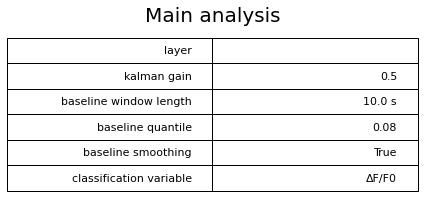

In [5]:
figs['dataset_info'] = plot_table({
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    'baseline smoothing': baseline_smoothing,
    'classification variable': ykey_classification
    }, title='Main analysis')

### Load data

In [6]:
stats = load_rtypeavg_stats(rtypeavg_dir)
stats = stats[stats[Label.DC] > 1.]
stats

 16/11/2022 20:39:36: loading data from /Users/tlemaire/Documents/data/usnm/rtype-averaged/w10.0s_q0.08_smooth/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main:
 16/11/2022 20:39:36: repsonder-type-averaged stats successfully loaded for lines line3, pv, sst


trial_length  duration (s)   fps  P (MPa)  DC (%)  \
line  responder type run                                                      
line3 negative       0           100.0           0.2  3.56     0.00    50.0   
      positive       0           100.0           0.2  3.56     0.00    50.0   
      weak           0           100.0           0.2  3.56     0.00    50.0   
      negative       1           100.0           0.2  3.56     0.10    50.0   
      positive       1           100.0           0.2  3.56     0.10    50.0   
...                                ...           ...   ...      ...     ...   
sst   positive       13          100.0           0.2  3.56     0.80    50.0   
      weak           13          100.0           0.2  3.56     0.80    50.0   
      negative       14          100.0           0.2  3.56     0.05    50.0   
      positive       14          100.0           0.2  3.56     0.05    50.0   
      weak           14          100.0           0.2  3.56     0.05    50.0   

                          run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
line  responder type run                                           
line3 negative       0     286.0        0.000000        0.000000   
      positive       0     286.0        0.000000        0.000000   
      weak           0     286.0        0.000000        0.000000   
      negative       1     291.0        0.309132        0.154566   
      positive       1     291.0        0.309132        0.154566   
...                          ...             ...             ...   
sst   positive       13    131.0       19.784475        9.892238   
      weak           13    131.0       19.784475        9.892238   
      negative       14    213.0        0.077283        0.038642   
      positive       14    213.0        0.077283        0.038642   
      weak           14    213.0        0.077283        0.038642   

                          pre-stimulus outlier?  count  ...  \
line  responder type run                                ...   
line3 negative       0                      0.0    812  ...   
      positive       0                      0.0   5640  ...   
      weak           0                      0.0   5991  ...   
      negative       1                      0.0    812  ...   
      positive       1                      0.0   5640  ...   
...                                         ...    ...  ...   
sst   positive       13                     0.0   1560  ...   
      weak           13                     0.0    217  ...   
      negative       14                     0.0     36  ...   
      positive       14                     0.0   1560  ...   
      weak           14                     0.0    217  ...   

                          post-stim avg event rate (Hz) - sem  \
line  responder type run                                        
line3 negative       0                               0.016351   
      positive       0                               0.006172   
      weak           0                               0.005569   
      negative       1                               0.016306   
      positive       1                               0.007348   
...                                                       ...   
sst   positive       13                              0.004250   
      weak           13                              0.027711   
      negative       14                              0.049803   
      positive       14                              0.004426   
      weak           14                              0.027984   

                          evoked event rate (Hz) change - mean  \
line  responder type run                                         
line3 negative       0                               -0.004199   
      positive       0                                0.009686   
      weak           0                                0.005755   
      negative       1                               -0.003379   
      positive       1                             

### Plot responder type distribution per mouse line

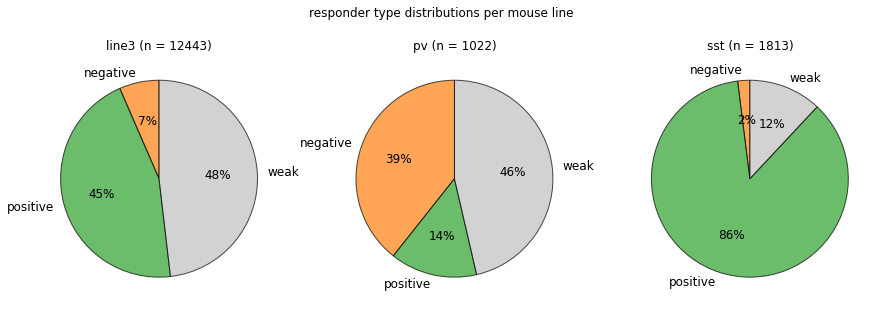

In [7]:
# Plot counts on pie chart
groups = stats.groupby(Label.LINE)
naxes = len(groups)
figs['rtype_dist_per_line'], axes = plt.subplots(1, naxes, figsize=(5 * naxes, 5))
figs['rtype_dist_per_line'].set_facecolor('w')
figs['rtype_dist_per_line'].suptitle('responder type distributions per mouse line')
for ax, (line, gdata) in zip(axes, groups):
    counts_by_rtype = gdata['count'].groupby(Label.ROI_RESP_TYPE).first()
    ax.set_title(f'{line} (n = {counts_by_rtype.sum()})')
    counts_by_rtype.plot.pie(
        ax=ax, ylabel='', autopct='%1.0f%%',
        colors=[Palette.RTYPE[k] for k in counts_by_rtype.index],
        startangle=90, textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'k', 'alpha': 0.7}
    )

### Plot parameter dependency curves 

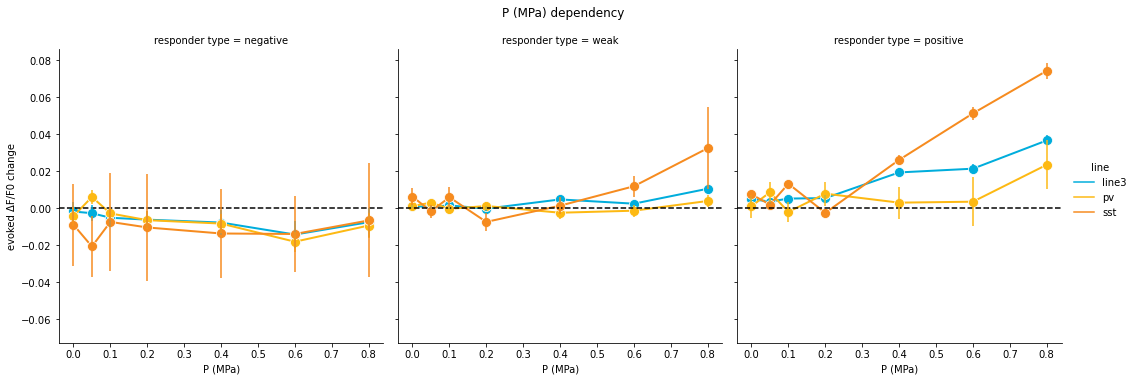

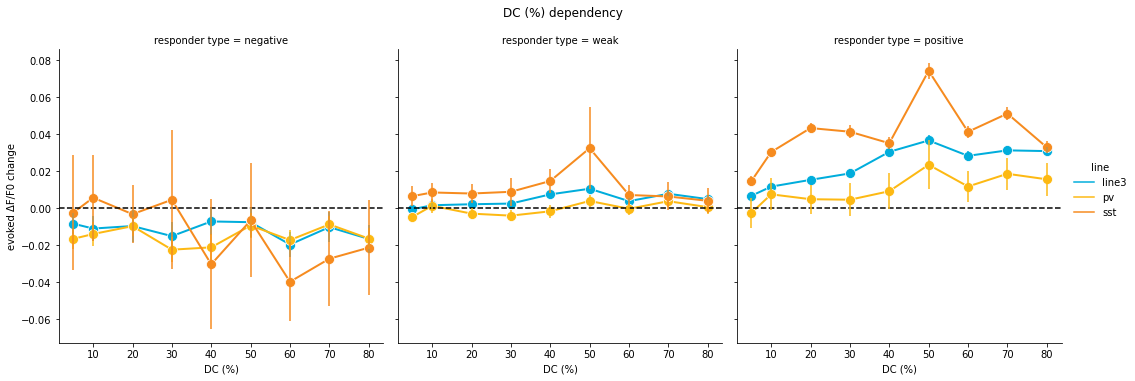

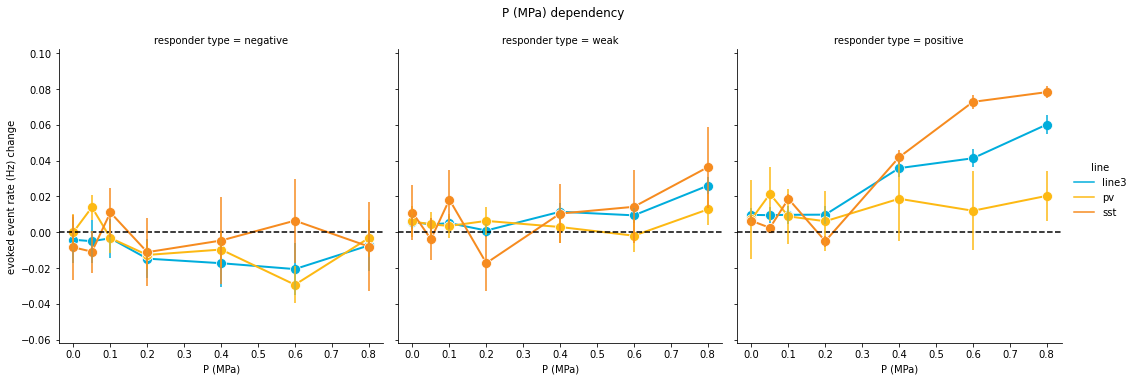

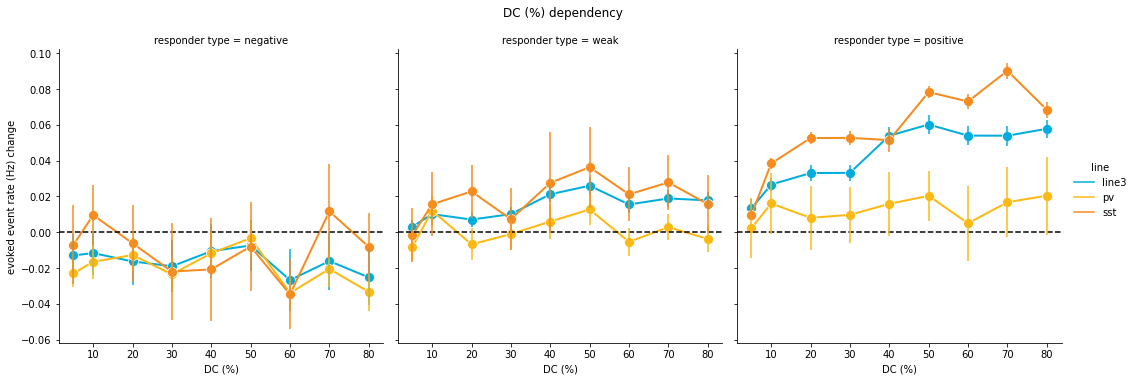

In [8]:
for ykey in [Label.DFF, Label.EVENT_RATE]:
    tmpaxes = []
    for xkey in [Label.P, Label.DC]:
        figkey = f'{ykey}_{xkey} dep'
        figs[figkey] = plot_parameter_dependency_across_lines(
            stats, xkey, get_change_key(ykey))
        tmpaxes = tmpaxes + figs[figkey].axes
    harmonize_axes_limits(np.asarray(tmpaxes))

### Plot Ispta dependency curves

 16/11/2022 20:40:05: plotting evoked ΔF/F0 change ISPTA dependency across responders...
 16/11/2022 20:40:05: plotting evoked event rate (Hz) change ISPTA dependency across responders...


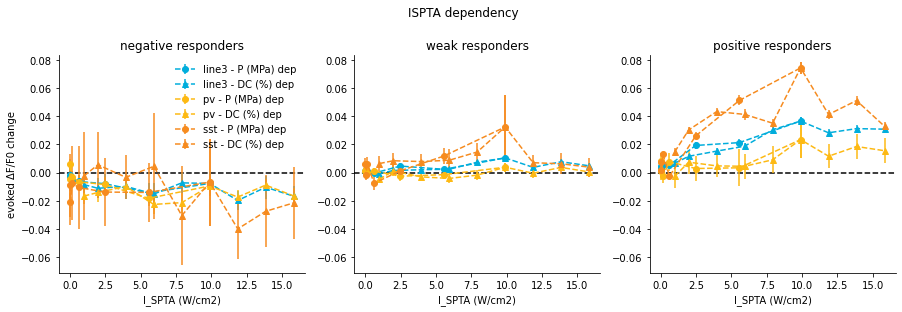

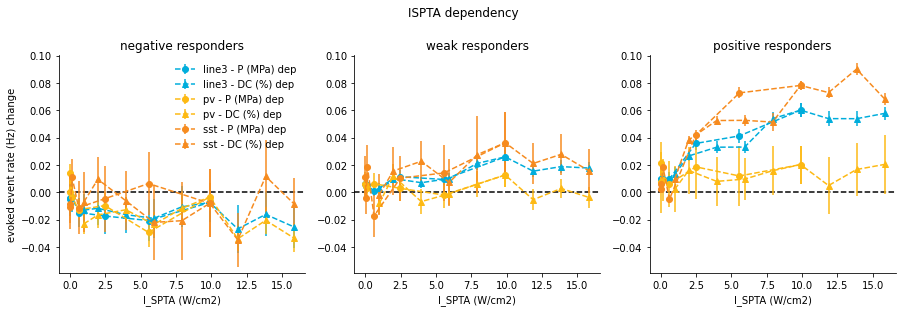

In [12]:
for ykey, ax in zip([Label.DFF, Label.EVENT_RATE], axes):
    figs[f'ispta_{ykey}_deps'] = plot_intensity_dependencies_across_lines(
        stats, get_change_key(ykey))

### Save figures

In [13]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 16/11/2022 20:40:07: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.11.16/figs_main_k0.5_w10.0s_q0.08_smooth_ΔFF0.pdf:


100%|██████████| 8/8 [00:01<00:00,  7.31it/s]


### Notify upon completion

In [11]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'main analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 16/11/2022 20:39:40: main analysis notebook completed in 0:00:03.976159 s
